# Extracting explanations from a sparse audio classifier

In [1]:
from audIBle.nn.autoencoders import SpecAE
from audIBle.nn.sparse_classif import SparseClassifier
from audIBle.data.datasets import UrbanSound8k

import torch
import numpy as np
import json
import os

In [2]:
config_ids = ["001", "002", "003"]
seed=42

id_idx = 1
exp_name = f"{config_ids[id_idx]}_sparse_classif_urbasound8k_{seed}"
exp_root = os.path.join(os.environ["EXP_ROOT"], "train/SAE/ae_debug/",exp_name)

with open(os.path.join(exp_root, "config.json"), 'r') as fh:
    cfg = json.load(fh)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')

autoencoder = SpecAE(**cfg["model"]["autoencoder"])
ae_ckpt_path = cfg["model"]["ae_ckpt_path"]
if ae_ckpt_path is not None:
    ae_ckpt = torch.load(ae_ckpt_path, map_location=device, weights_only=True)
    autoencoder.load_state_dict(ae_ckpt)

# prepare the sparse classifier
classif_params = cfg["model"]["classifier"]
classif_params["autoencoder"] = autoencoder
model = SparseClassifier(**classif_params)

In [4]:
# classifier checkpoint
classif_ckpt_path = os.path.join(exp_root,"best_model.pth")
ckpt = torch.load(classif_ckpt_path, map_location=device, weights_only=True)
model.load_state_dict(ckpt)

<All keys matched successfully>

In [5]:
data_root = "/lium/corpus/vrac/tmario/sed/urbansound8k/urbansound8k"
fold_test = 10
dataset = UrbanSound8k(csv_path=os.path.join(data_root, "metadata/UrbanSound8K.csv"),
                           audio_dir=os.path.join(data_root, "audio"),
                           sample_rate=cfg["sample_rate"],
                           folds_to_use=[10],)

In [6]:
def extract_explanation(model, tau, input_data, label, device):
    model.to(device)

    # extract all of the representations
    all_rep = model.forward_return_all(input_data.to(device))
    # pooled sparse representation (used to make the decision)
    Z = all_rep["sparse_latent_pooled"]
    
    # weights of the linear classification head
    W_c = model.classif_head.weight
    # weights of the SAE decoder
    W_d_sae =  model.sae.decoder.weight

    # predicted class 
    pred = torch.argmax(torch.nn.functional.softmax(all_rep["logits"], dim=-1),dim=-1)
    n_classes = W_c.shape[0]
    
    explain = {"model_outputs": all_rep, "explain": {}}

    for c in range(n_classes):
        # select the weights of the classification layer according to class c
        w_class = W_c[c,:]
        # compute class relevance based on classification head weights
        #TODO check the formula w.r.t. the JSALT code
        r_c = w_class * Z 
        r_c = r_c / r_c.max() 
        # binarize based on a threshold
        mask = r_c > tau

        Z_seq = all_rep["sparse_latent"]
        # mask the latent representation according to the relevant dimensions
        Z_seq_mask = Z_seq * mask.unsqueeze(1)

        # decode the latent space of the SAE after selecting the relevant dimensions 
        sae_dec_mask = model.sae.decoder(Z_seq_mask)
        # decode to the spectrogram domain
        spec_dec_mask = model.audio_ae.decode(sae_dec_mask.permute(0,2,1))

        explain["explain"][f"class_{c}"] = {"relevance": r_c, 
                                 "bin_relevance": mask, 
                                 "relevant_spec": spec_dec_mask,
                                 "label": label, 
                                 "pred": pred,}
    return explain

In [7]:
import matplotlib.pyplot as plt

def plot_explain_spec(x_orig, x_explain, attention_weights=None, **plt_kw):
    sr = plt_kw.get("samplerate", 22050)
    class_id = plt_kw.get("class_id", "")
    fig, axs = plt.subplots(3, 1, figsize=(8, 7), sharex=True, layout="tight")
    title_info = plt_kw.get("title", "")
    # Plot original and explanation spectrograms
    for ax, spec, title in zip(
        axs[:2], [x_orig, x_explain], [f"Original", f"Explanation"]
    ):
        # assume input is torch.Tensor or np.ndarray, shape (1, freq, time) or (freq, time)
        if hasattr(spec, "detach"):
            spec = spec.detach().cpu().squeeze().numpy()
        else:
            spec = np.squeeze(spec)
        im = ax.imshow(
            spec,
            aspect="auto",
            origin="lower",
            cmap="magma",
            interpolation="nearest",
        )
        title  = title + title_info
        ax.set_title(title)
        # Set y-axis in Hz
        n_freq = spec.shape[0]
        y_ticks = np.linspace(0, n_freq - 1, 6)
        y_labels = np.linspace(0, sr // 2, 6, dtype=int)
        ax.set_yticks(y_ticks)
        ax.set_yticklabels(y_labels)
        ax.set_ylabel("Frequency (Hz)")
        # Set x-axis in seconds
        n_time = spec.shape[1]
        x_ticks = np.linspace(0, n_time - 1, 6)
        x_labels = np.round(np.linspace(0, n_time / sr, 6), 2)
        ax.set_xticks(x_ticks)
        ax.set_xticklabels(x_labels)
        # Place colorbar on top
        cbar = fig.colorbar(im, ax=ax, orientation="horizontal", pad=0.2)
        cbar.ax.xaxis.set_ticks_position('top')
        cbar.ax.xaxis.set_label_position('top')

    # Plot attention weights
    if attention_weights is not None:
        if hasattr(attention_weights, "detach"):
            attn = attention_weights.detach().cpu().squeeze().numpy()
        else:
            attn = np.squeeze(attention_weights)
        # attn shape: (time,) or (1, time)
        axs[2].plot(attn, color="tab:blue")
        axs[2].set_ylabel("Attention weight")
        axs[2].set_title("Attention weights over time")
        axs[2].set_ylim(0, np.max(attn) * 1.1)
        n_time = attn.shape[-1]
        x_ticks = np.linspace(0, n_time - 1, 6)
        x_labels = np.round(np.linspace(0, n_time / sr, 6), 2)
        axs[2].set_xticks(x_ticks)
        axs[2].set_xticklabels(x_labels)
        # Align attention x-axis with spectrograms
        axs[2].set_xlim(axs[0].get_xlim())
    axs[-1].set_xlabel("Time (s)")
    plt.tight_layout()
    plt.show()



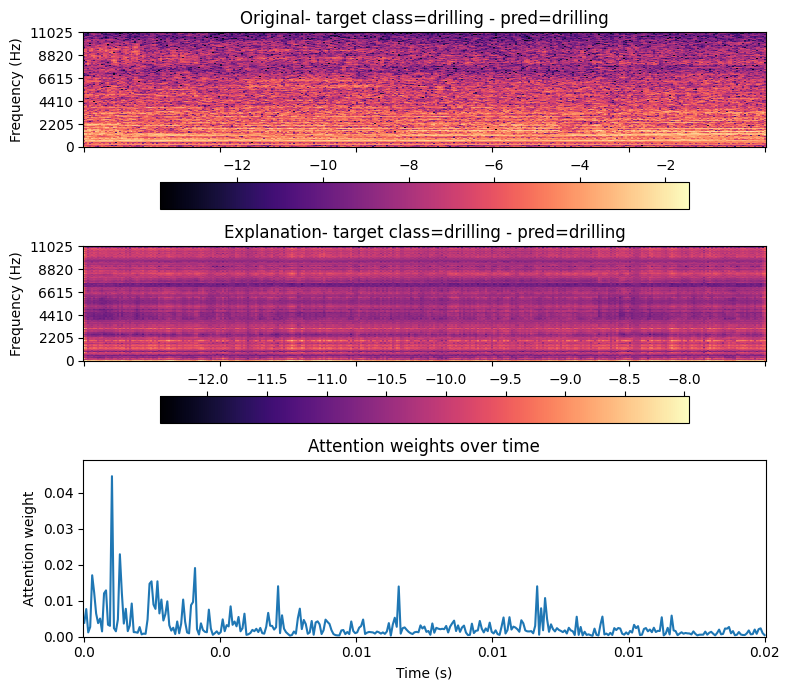

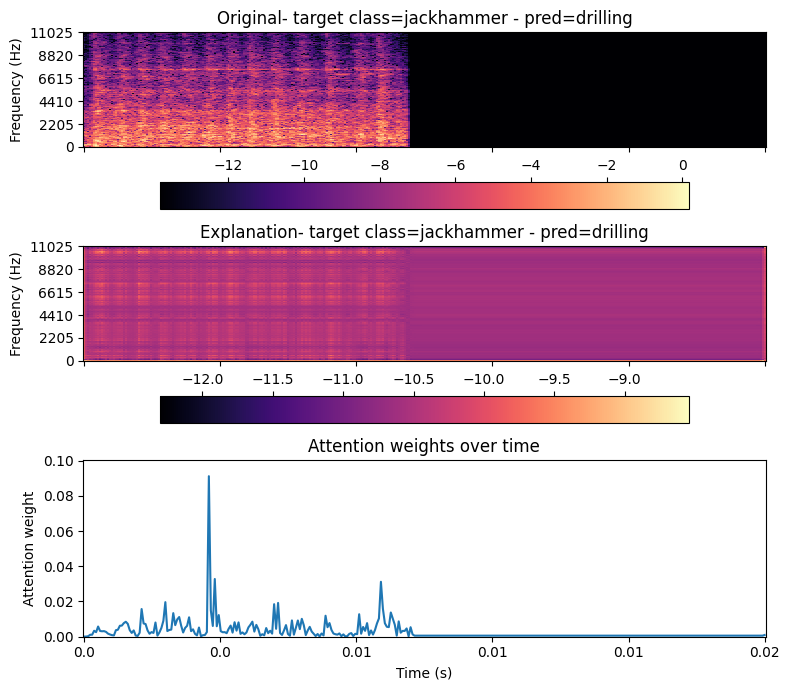

Wrong classification!


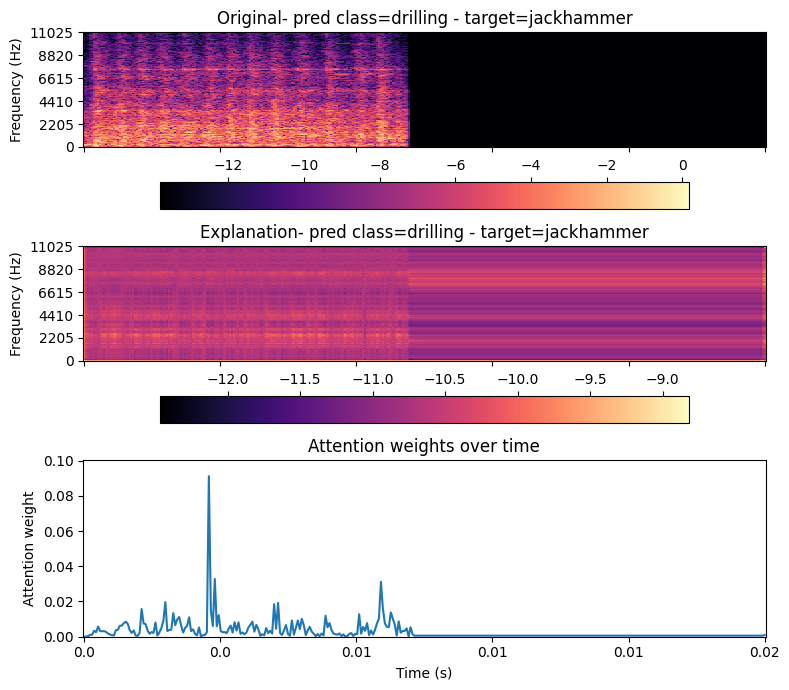

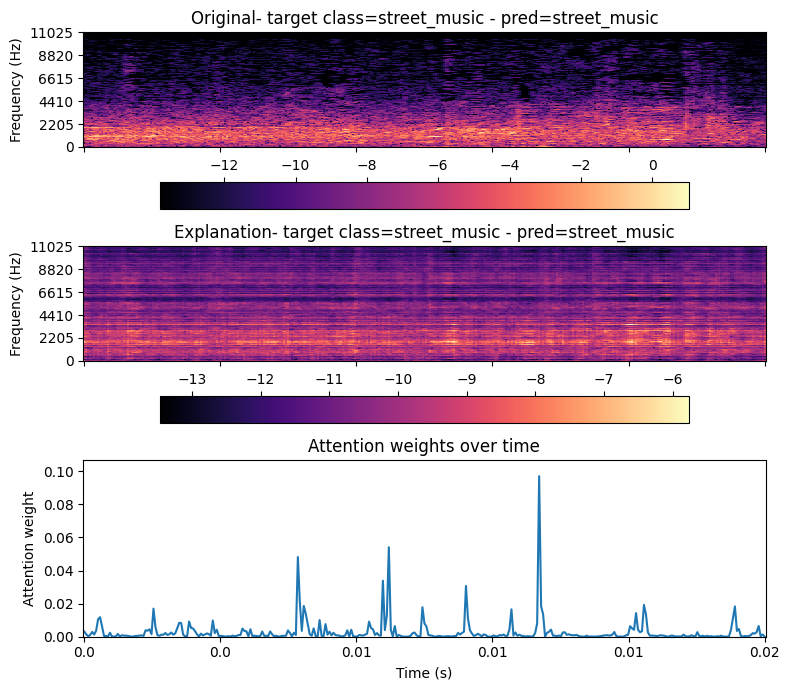

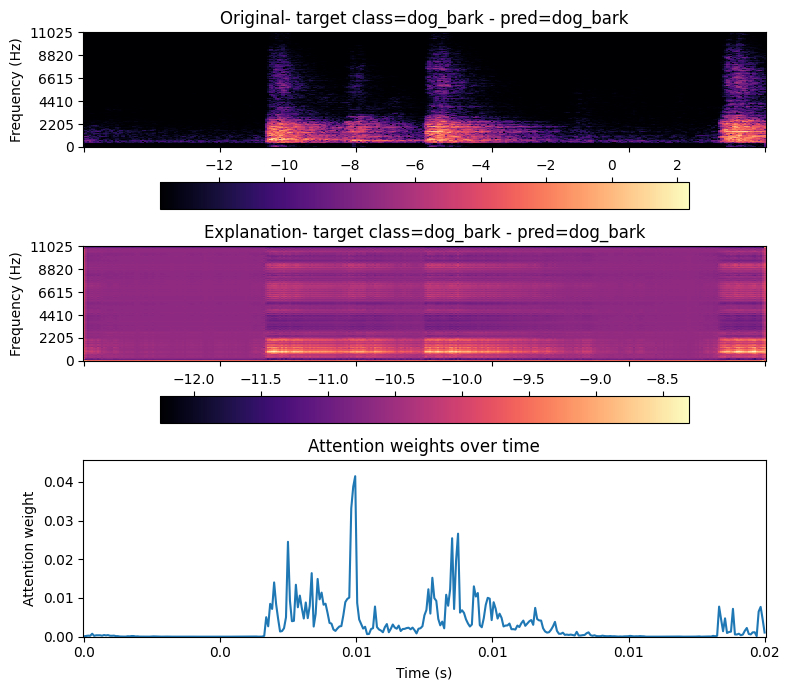

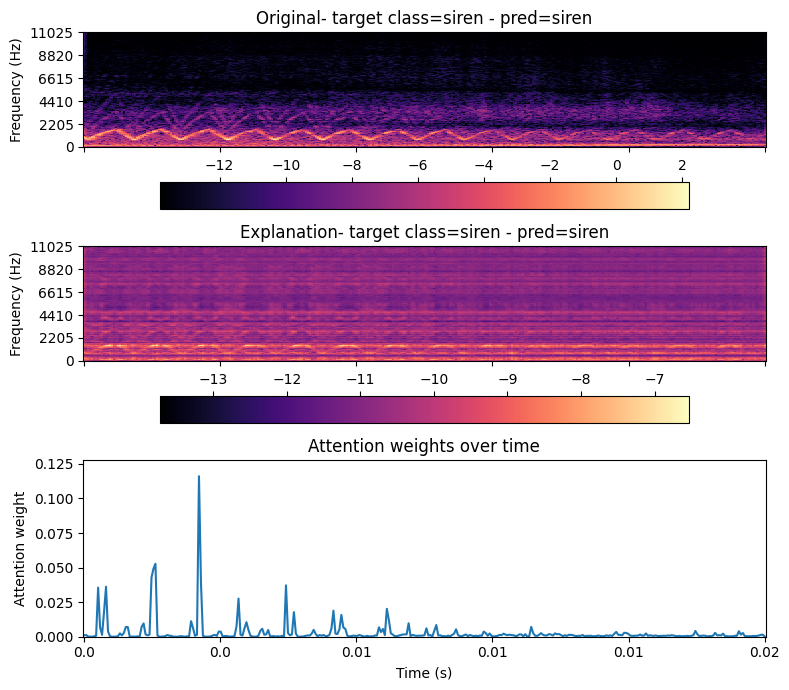

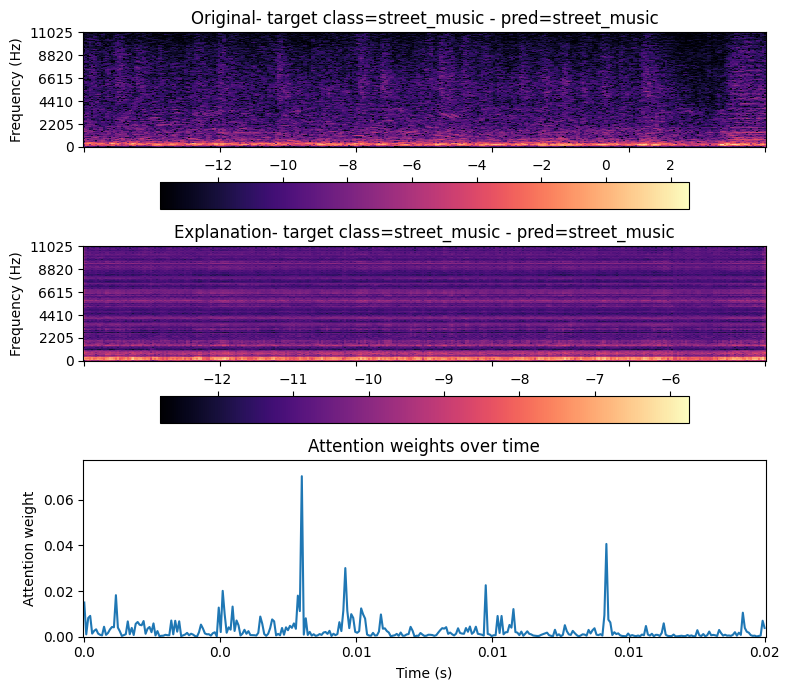

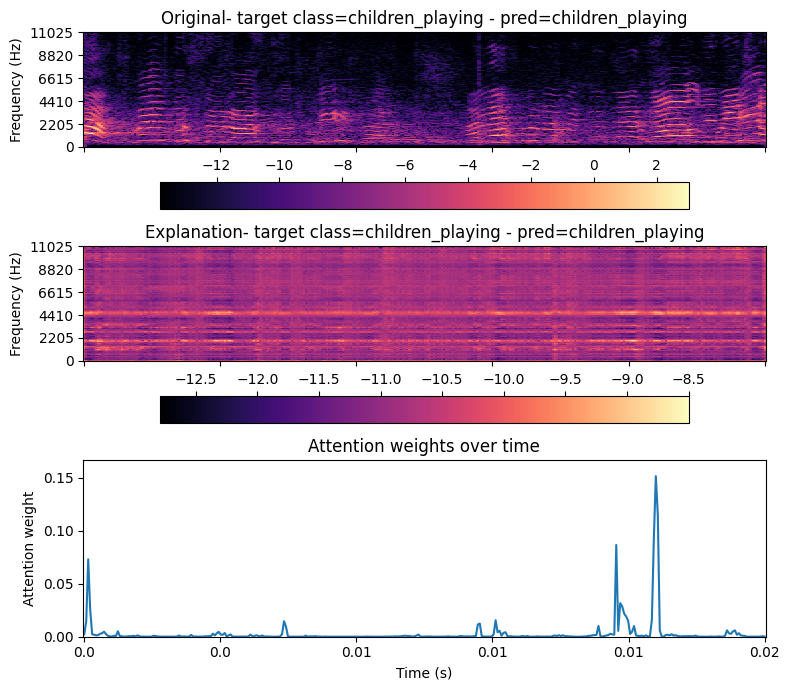

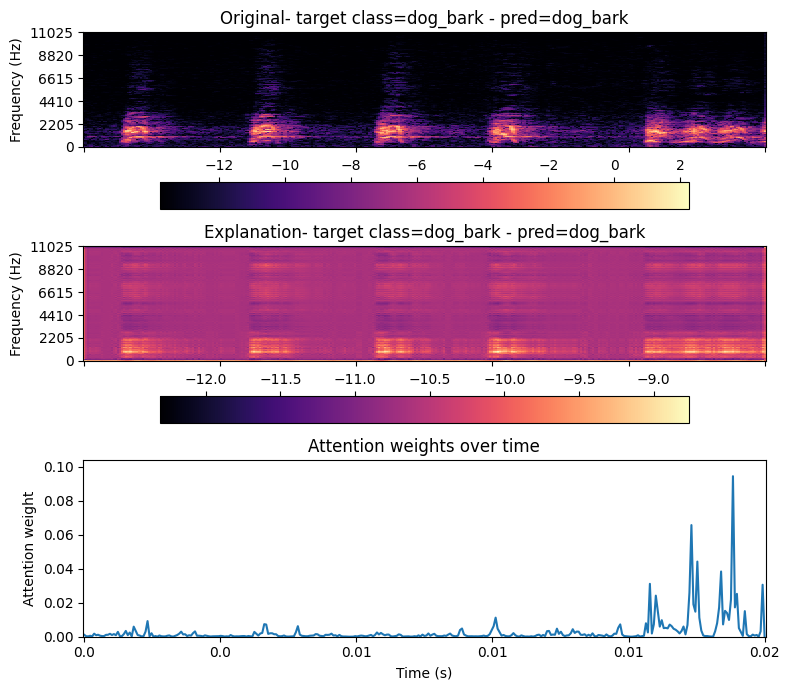

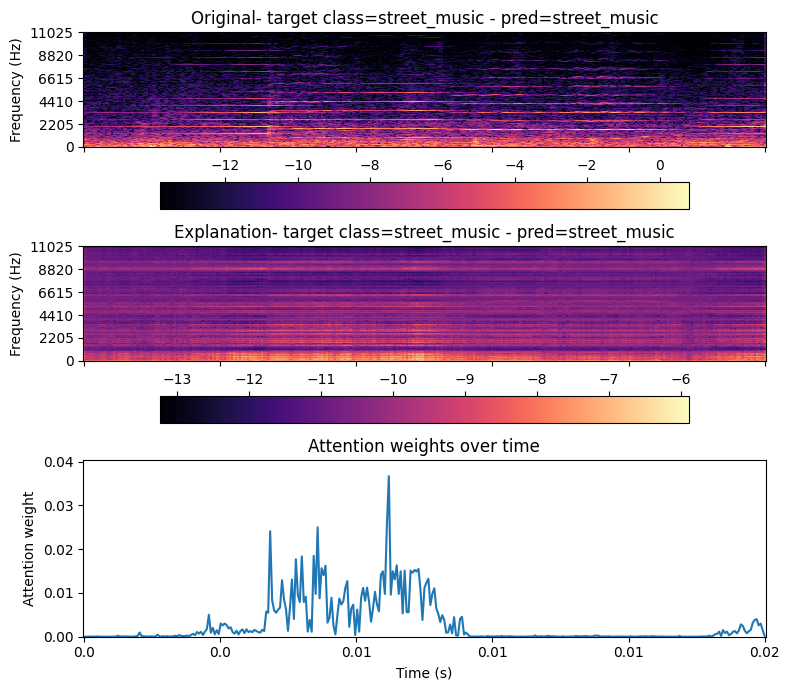

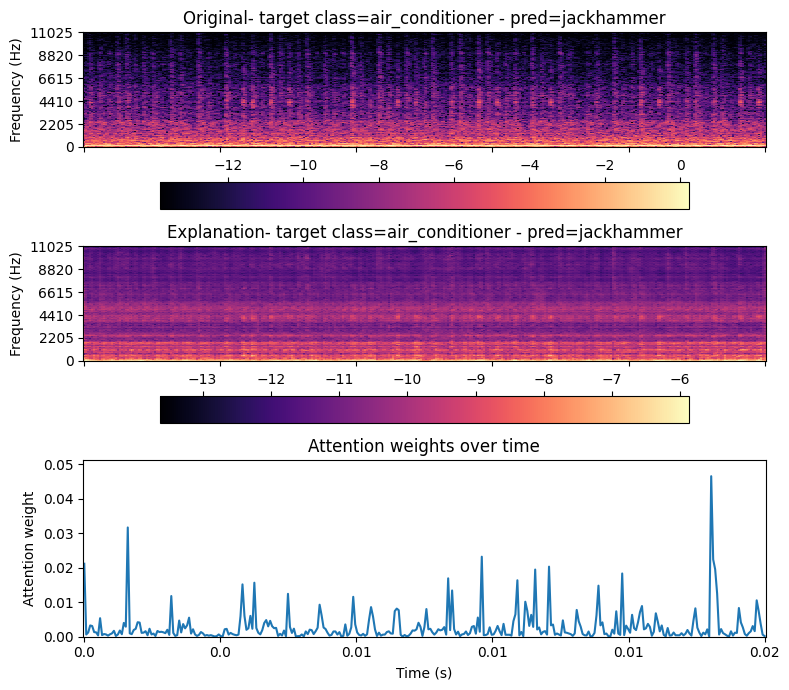

Wrong classification!


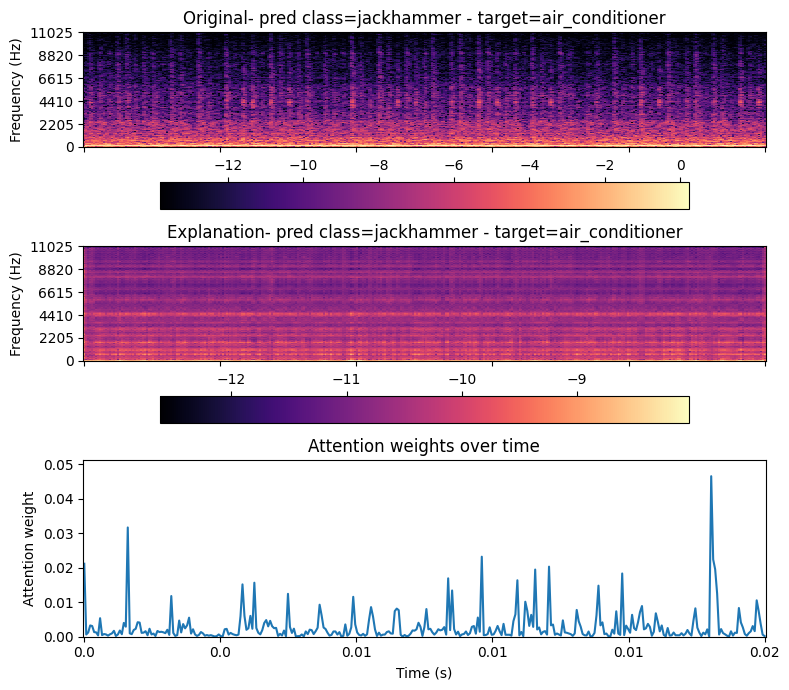

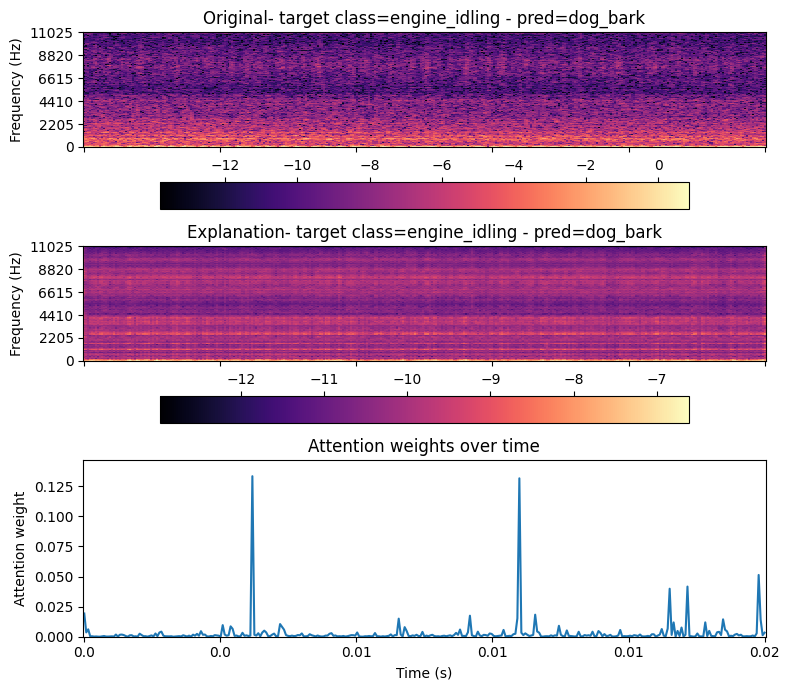

Wrong classification!


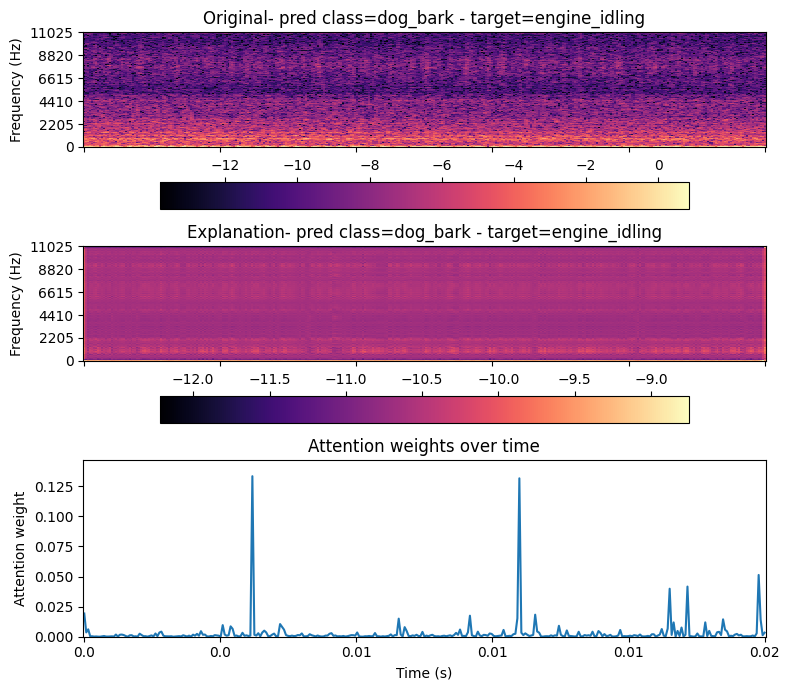

In [9]:
model.to(device)
W_c = model.classif_head.weight
W_sae_d = model.sae.decoder.weight
tau = 0.5

from torch.utils.data import DataLoader
import IPython.display as ipd

test_loader = DataLoader(dataset=dataset, batch_size=1, shuffle=True)
classes = dataset.classes
for i_data, (wav, label) in enumerate(test_loader):
    #wav, label = dataset[i_data]
    #wav = wav.unsqueeze(0)
    label = label.squeeze()
    # all_rep = model.forward_return_all(wav.to(device))

    # for k,v in all_rep.items():
    #     print(f"{k}: {v.shape}")
    
    ipd.display(ipd.Audio(wav.detach().cpu().squeeze().numpy(),rate=cfg["sample_rate"]))

    explain = extract_explanation(model, tau, wav, label, device)
    model_outputs = explain["model_outputs"]   
    # for k in model_outputs.keys():
    #     print(k)

    pred_class = explain["explain"][f"class_{label}"]["pred"]
    
    spec_orig = model_outputs["spec"]
    attention_weights = model_outputs["attention_weights"]
    
    plot_explain_spec(x_orig=spec_orig, 
                    x_explain=explain["explain"][f"class_{label}"]["relevant_spec"], 
                    attention_weights=attention_weights, 
                    class_id="pouet", 
                    samplerate = cfg["sample_rate"],
                    title=f"- target class={classes[label.item()]} - pred={classes[pred_class.item()]}")
    
    if pred_class.item() != label.item():
        print("Wrong classification!")
        plot_explain_spec(x_orig=spec_orig, 
                    x_explain=explain["explain"][f"class_{pred_class.item()}"]["relevant_spec"], 
                    attention_weights=attention_weights, 
                    class_id="pouet", 
                    samplerate = cfg["sample_rate"],
                    title=f"- pred class={classes[pred_class.item()]} - target={classes[label.item()]}")
        

    if i_data >=10:
        break

### Plot the distribution of activated sparse dimensions per class

### Visualize the sparse sequence (before pooling) for a few examples